**Por: David Santiago Flórez Alsina**    

Empezamos por definir unas clases base que son clave para trabajar cómodamente todas las operaciones:

1. Clase Vector
2. Clase Segmento
3. Clase convex hull (encargada de ejecutar el convex hull de un set de puntos).
4. Clase polígono 
5. Clase VectorPlotter (encargada de plotear vectores)

Clase vector
-----------------

In [1]:
# standard dependencies
import numpy as np 
from typing import Union, List, Tuple
import matplotlib.pyplot as plt


#we are using some new concepts to me, like:
# - forward annotations, to use the class Vector before it's defined
# - unpacking operator (*), to pass a variable number of arguments to a function

class Vector:
    def __init__(self, vector: np.ndarray):
        
        #it's a column vector
        if (vector.shape[0] > 1) and (vector.shape[1] == 1):
            self.vector = vector
            self.T = vector.T
            self.ndimensions = self.vector.shape[0]
        
        #it's a row vector
        elif (vector.shape[1] > 1) and (vector.shape[0] == 1):
            self.vector = vector.T
            self.T = vector.T
            self.ndimensions = self.vector.shape[0]
        else:
            raise TypeError(f"Should be a row or a column vector, yet has shape: {vector.shape}")

    #================================================
    #            Some important operations
    #================================================

    def calculate_slope(self, vector2: 'Vector') -> float:
        """
            Calculates the slope between self and vector2.

            Input:
                vector2: Vector
            Output:
                slope: float
        """

        if self[0] == vector2[0]:
            return np.inf
        return (self[1] - vector2[1]) / (self[0] - vector2[0])


    def calculate_distance(self, vector2: 'Vector') -> float:
        """
            Calculates the distance between self and vector2.

            Input:
                vector2: Vector
            Output:
                distance: float
        """
        return np.linalg.norm(self.vector - vector2.vector)
    
    def get_furthest_point(self, points: List['Vector']) -> 'Vector':

        """
            Finds the furthest point from self.

            Input:
                points: Vector or List[Vector]
            Output:
                furthest_point: Vector
        """

        # calculate the distance from v0 to each point
        distances = [self.calculate_distance(point) for i, point in enumerate(points)]
        
        # find the maximum distance
        maxdist = max(distances)

        # find the indexes of the points with the maximum distance
        indexes = [i for i, d in enumerate(distances) if d == maxdist]

        return points[indexes[0]]

    #================================================
    #               Static methods
    #================================================
    @staticmethod
    def build_random_vectors(nvectors:int, minval = -10, maxval = 10) -> List['Vector']:
        vectors = []
        for i in range(nvectors):
            vectors.append(Vector(np.random.randint(minval, maxval, (2, 1))))

        return vectors
    
    @staticmethod
    def cast_to_vector(vectors: List[np.ndarray]) -> List['Vector']:
        return [Vector(vector) for vector in vectors]


    #================================================
    #               Operator overloading
    #================================================
    def __add__(self, vector2: 'Vector') -> 'Vector':
        return Vector(self.vector + vector2.vector)
    
    def __sub__(self, vector2: 'Vector') -> 'Vector':
        return Vector(self.vector - vector2.vector)
    
    def __mul__(self, other: 'Vector') -> 'Vector':
        if isinstance(other, float): 
            return Vector(self.vector * other)

        elif isinstance(other, Vector): 
            return Vector(self.vector * other.vector)
        else: 
            return NotImplemented

    def __rmul__(self, other):
        return self.__mul__(other) 
    
    def __truediv__(self, number: float) -> 'Vector':
        return Vector(self.vector / number)

    def __getitem__(self, index: int) -> float:
        return self.vector[index][0]

    def __repr__(self):
        return f"Vec({self.vector[0][0]}, {self.vector[1][0]})"

    def __str__(self):
        return f"Vec({self.vector[0][0]}, {self.vector[1][0]})"

    #================================================
    #              Order relations overloading
    #================================================

    def __eq__(self, vector: 'Vector') -> bool:
        return (self[0] == vector[0]) and (self[1] == vector[1])

    def __ne__(self, vector: 'Vector') -> bool:
        return (self[0] != vector[0]) or (self[1] != vector[1])

    def __gt__(self, vector2: 'Vector') -> bool:
        return (self[1] > vector2[1]) or (self[1] == vector2[1] and self[0] < vector2[0])
    
    def __lt__(self, vector2: 'Vector') -> bool:
        return (not (self > vector2)) and (self != vector2)
    
    def __ge__(self, vector2: 'Vector') -> bool:
        return (self > vector2) or (self == vector2)
    
    def __le__(self, vector2: 'Vector') -> bool:
        return (self < vector2) or (self == vector2)
    




Clase Segmento
----------  

In [2]:

class Segment():

    def __init__(self, start: Vector, end: Vector, sort_ends = False) -> None:
        """
            This class is used to represent a segment in 2D space.
            start and end are the vertices of the segment. Starting from start, and ending in end.
        """
        self.start = start
        self.end = end

        #make sure that the start is the lowest leftmost point, 
        #refer to our order operator overload in vector.py
        if sort_ends and (self.start > self.end):
            self.start, self.end = self.end, self.start


    def get_midpoint(self) -> Vector:
        """
            Calculates the midpoint of the segment.
        """
        return (self.start + self.end)/2

    def calcutale_slope(self) -> float:
        """
            Calculates the slope of segment.
        """
        deltas = self.end - self.start

        if deltas[0] == 0:
            return np.inf

        return (deltas[1])/(deltas[0])
        
    def calculate_distance(self) -> float:
        """
            Calculates the distance between end and v2.
        """
        return np.linalg.norm(self.end - self.start)

    
    def on_segment_area(self, v3: Vector) -> bool:
        """
            Checks if v3 is on the segment startend area,
            this area is defined by the rectangle with vertices start and end.
        """
        inx = min(self.start[0], self.end[0]) <= v3[0] <= max(self.start[0], self.end[0]) 
        iny = min(self.start[1], self.end[1]) <= v3[1] <= max(self.start[1], self.end[1])

        if (inx and iny):
            return True
        return False

    def direction(self, vector3: Vector) -> int:
        """
            Given our segment, and a vector3, determine if vector3 is rotated clockwise or anticlockwise, 
            or if they are colineal, with respect to the segment.
        """
        det = np.linalg.det(np.column_stack([(vector3 - self.start).vector, (self.end - self.start).vector]))

        if det < 0:
            return -1
        elif det > 0:
            return 1
        return 0

    def segments_intersect(self, other_segment: 'Segment') -> bool:

        """
            Given one segment, determine if the segments they form intersect.
            Segments are startend from self, and startend from other_segment.
        """

        #directions with respect to other_segment
        dir1 = other_segment.direction(self.start)
        dir2 = other_segment.direction(self.end)
        
        #directions with respect to self
        dir3 = self.direction(other_segment.start)
        dir4 = self.direction(other_segment.end)

        #well behaved case
        if (dir1*dir2 < 0) and (dir3*dir4 < 0):
            return True
    
        #collinear case with respect to other_segment
        elif (dir1 == 0) and (other_segment.on_segment_area(self.start)):
            return True

        elif (dir2 == 0) and (other_segment.on_segment_area(self.end)):
            return True

        #collinear case with respect to self
        elif (dir3 == 0) and (self.on_segment_area(self.on_segment_area.start)):
            return True

        elif (dir4 == 0) and (self.on_segment_area(self.on_segment_area.end)):
            return True
        
        else:
            return False
    
    def find_intersection(self, other_segment: 'Segment') -> Vector:
        """
            Finds the intersection of the lines formed by the segments endv2 and v3v4.
        """

        difference1 = (self.start - self.end).vector
        difference2 = (other_segment.start - other_segment.end).vector
        result = (other_segment.start - self.end).vector

        matrix = np.column_stack([difference1, difference2])
        alpha_beta = np.linalg.solve(matrix, result)

        intersect = self.start*float(alpha_beta[0]) + float(1 - alpha_beta[0])*self.end

        print(f"alpha: {alpha_beta[0]}, beta: {alpha_beta[1]}, intersect: {intersect}")
        print(f"intersect type {alpha_beta[0].shape}")

        return intersect

    @staticmethod
    def build_random_segments(nsegments: int=10)-> List['Segment']:
        """
            Builds nsegments random segments.
        """
        segments = []

        for _ in range(nsegments):
            start = Vector.build_random_vectors(1)[0]
            end = Vector.build_random_vectors(1)[0]
            segments.append(Segment(start, end))

        return segments

    def __repr__(self) -> str:
        return f"Segment({self.start}, {self.end})"


Clase ConvexHull
----------------------

In [3]:
class ConvexHull:

    def __init__(self):
        pass

    #========================================
    #           Small subroutines
    #========================================
    def get_starting_point(self, points: List[Vector]) -> Vector:
        """
            Returns the smallest point in the x coordinate, if there are more than one,
            returns the smallest in the y coordinate.
        """

        minimumx = min([point[0] for point in points])
        indexesx = [i for i, p in enumerate(points) if p[0] == minimumx]
        minimum_x_points = [points[i] for i in indexesx]

        #if there are more than one point with the smallest x coordinate
        minimumy = min([point[1] for point in minimum_x_points])
        indexesy = [i for i, p in enumerate(minimum_x_points) if p[1] == minimumy]

        return minimum_x_points[indexesy[0]]


    def find_repeated_and_unique_slopes(self, slopes: List[float]) -> Tuple[List[int], List[int]]:

        """
            Finds the indexes of the repeated slopes.

            Returns:
                all_repeated_indexes: list of lists with the indexes of the repeated slopes. Each sublist corresponds to a group of repeated slopes.
                all_unique_indexes: list with the indexes of the unique slopes.     
        """

        # list of lists, each sublist corresponds to a group of indexes of repeated slopes
        all_repeated_indexes = []
        # list of indexes of unique slopes
        all_unique_indexes = []

        for i, slope in enumerate(slopes):
            indexes = [j for j, s in enumerate(slopes) if s == slope and j != i]

            if indexes:
                all_repeated_indexes.append(indexes)
            else:
                all_unique_indexes.append(i)

        
        return all_repeated_indexes, all_unique_indexes



    def sort_by_slope(self, v0: Vector, points: List[Vector]) -> list:

        """
            Sorts the points by the slope in ascending order.
            The slope is computed with respect to v0.

            If there are more than one point with the same slope,
            the one further away to v0 is chosen.
        """

        # calculate the slope of each point with respect to v0
        slopes = [v0.calculate_slope(point) for point in points]

        # find the repeated slopes indexes
        repeated_slopes_idx, unique_slopes_idx = self.find_repeated_and_unique_slopes(slopes)

        # list with the points which have a unique slope or the furthest point from v0
        filtered_points = [points[i] for i in unique_slopes_idx]

        # if there are repeated slopes, find the furthest point from v0 to each repeated slope
        # and prefer it over the other points with the same slope
        for indexes in repeated_slopes_idx:
            repeated_points = [points[i] for i in indexes]
            furthest_point = v0.get_furthest_point(repeated_points)
            filtered_points.append(furthest_point)

        # sort the filtered points by the slope in ascending order
        slopes = [(point, v0.calculate_slope(point)) for i, point in enumerate(filtered_points)]
        slopes.sort(key = lambda x: x[1])

        return [point for point, slope in slopes]


    #========================================
    #           Main algorithm
    #========================================

    def convex_hull(self, points: List[Vector]) -> list:

        """
            Computes the convex hull of a set of points in the plane.
            The points must be given in the form of numpy arrays.
        """

        #gets the leftmost lowest point
        v0 = self.get_stating_point(points)

        #based on this leftmost lowest point, sort the points by the slope in ascending order
        sorted_points = self.sort_by_slope(v0, points)

        #initialize the convex hull with the first three points
        convex_hull = [v0, sorted_points[0], sorted_points[1]]

        for n in range(2, len(sorted_points)):

            v1 = convex_hull[-2]    # second to last point in the convex hull
            v2 = convex_hull[-1]    # last point in the convex hull
            v3 = sorted_points[n]   # next point to be added to the convex hull
            
            #This loop is what i'd call the fixing mistakes (or dropping) loop:

            # while there are more than two points in the convex hull
            # and v3 is rotated anticlockwise with respect to the v1-v2 line
            while len(convex_hull) > 2 and (Segment(v1, v2).direction(v3) >= 0):
                # remove v2 from the convex hull,
                # because it is not part of the convex hull                
                convex_hull.pop()       
                                        
                v1 = convex_hull[-2]
                v2 = convex_hull[-1]
            
            # add v3 to the convex hull
            convex_hull.append(v3)


        return convex_hull

Clase Poligono
---------------

In [4]:
class Poligon:

    def __init__(self, vertex_set: List[Vector]):
        self.vertex_set = vertex_set
        self.convex_hull = ConvexHull()

    def __str__(self):
        return str(self.vertex_set)
    
    def __repr__(self):
        return str(self.vertex_set)

    def check_directions(self, directions: list[int]) -> bool:
        """
            Checks if there is at least one direction which goes the opposite to the rest.
        """
        count = {0: 0, 1: 0, -1: 0}

        for direction in directions:
            count[direction] += 1

        if (count[1] * count[-1]) > 0:
            return True
        return False

    def is_convex(self):

        #gets the leftmost lowest point
        self.starting_point = self.convex_hull.get_starting_point(self.vertex_set)

        #based on this leftmost lowest point, sort the points by the slope in ascending order
        self.vertex_set = self.convex_hull.sort_by_slope(self.starting_point, self.vertex_set)

        #get the first two points
        v1 = self.vertex_set[0]
        v2 = self.vertex_set[1]

        #print(f"type of v1: {type(v1)}")
        directions = []

        for v in self.vertex_set[2:]:
            segment = Segment(v1, v2)
            directions.append(segment.direction(v))
            #print(directions)

            v1 = v2
            v2 = v

            #if there is at least one turn which goes the opposite to the rest 
            #then the poligon is not convex
            if (len(directions) > 1) and self.check_directions(directions):
                return False

        return True   

Clase para mostrar vectores
------------------------------

In [5]:
class VectorPlotter:

    def __init__(self):
        pass

    @staticmethod
    def show():
        plt.show()

    @staticmethod
    def plot(v1: Vector, arrow: bool = False, highlighted: bool = False) -> None:
        
        if arrow:
            plt.arrow(0, 0, v1.vector[0][0], v1.vector[1][0], head_width=0.1, head_length=0.1, color="g")
            norm = np.linalg.norm(v1.vector)
            plt.xlim(-2*norm, 2*norm)
            plt.ylim(-2*norm, 2*norm)
        elif highlighted:
            plt.scatter(v1.vector[0][0], v1.vector[1][0], color="b", s=30, marker="X")
            plt.text(v1.vector[0][0], v1.vector[1][0], f"V")
        else:
            plt.scatter(v1.vector[0][0], v1.vector[1][0], color="b", s=20)
            norm = np.linalg.norm(v1.vector)
            plt.xlim(-1*norm, 1*norm)
            plt.ylim(-1*norm, 1*norm)


    @staticmethod
    def plot_many(vectors: List[Vector],
                   highlighted: list = [],
                   with_arrows: bool = False,
                   with_labels: bool = False):

        for i, vector in enumerate(vectors):
            if with_arrows:
                plt.arrow(0, 0, vector.vector[0][0], vector.vector[1][0], head_width=0.1, head_length=0.1, color="g")
            else: 
                plt.scatter(vector.vector[0][0], vector.vector[1][0], color="g", s=7)

            if with_labels:
                plt.text(vector.vector[0][0], vector.vector[1][0], f"v{i}")


        for vector in highlighted:
            #marker is a cross sign 
            plt.scatter(vector.vector[0][0], vector.vector[1][0], color="b", s=20, marker="X")

        norm = max([np.linalg.norm(v.vector) for v in vectors])

        plt.xlim(-1*norm, 1*norm)
        plt.ylim(-1*norm, 1*norm)

Ahora sí manos a la obra:
------------------------

is poligon ex. 1 convex? True


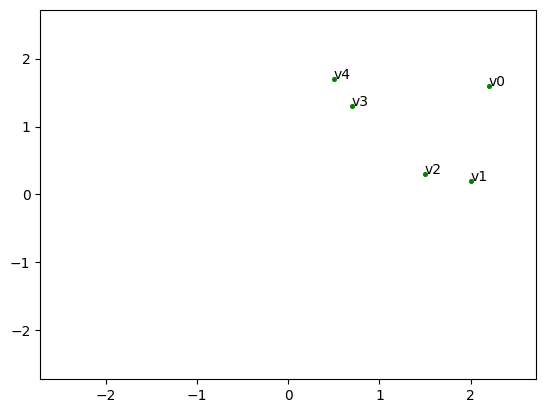

In [6]:
#===============================================================================
# example 1
plotter = VectorPlotter()
vectors1 = [np.array([[2.2], [1.6]]), np.array([[2.0], [0.2]]),
           np.array([[1.5], [0.3]]), np.array([[0.7], [1.3]]), 
           np.array([[0.5], [1.7]]), ]
vectors1 = Vector.cast_to_vector(vectors1)

p1 = Poligon(vectors1)
print(f"is poligon ex. 1 convex? {p1.is_convex()}")
plotter.plot_many(vectors1, with_labels=True)
plotter.show()

is poligon ex. 2 convex? False


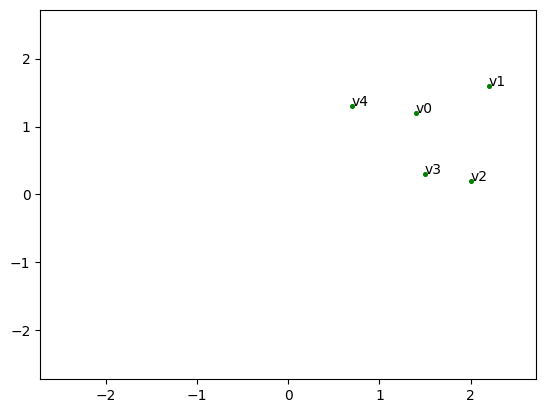

In [7]:
#===============================================================================
# example 2
vectors2 = [np.array([[1.4], [1.2]]), np.array([[2.2], [1.6]]),
            np.array([[2.0], [0.2]]), np.array([[1.5], [0.3]]), 
            np.array([[0.7], [1.3]]), ]
vectors2 = Vector.cast_to_vector(vectors2)

p2 = Poligon(vectors2)
print(f"is poligon ex. 2 convex? {p2.is_convex()}")
plotter.plot_many(vectors2, with_labels=True)
plotter.show()

is poligon ex. 3 convex? True


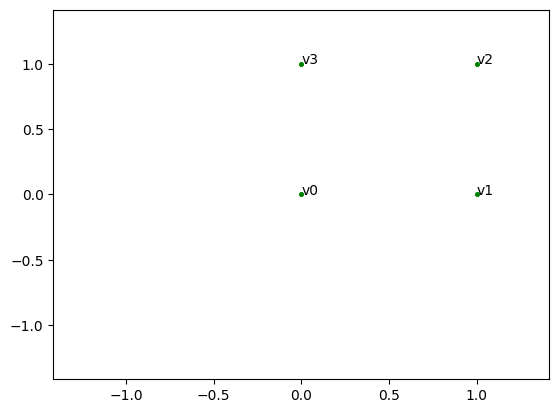

In [8]:
#===============================================================================
# example 3

#a square
vectors3 = [np.array([[0], [0]]), np.array([[1], [0]]),
            np.array([[1], [1]]), np.array([[0], [1]]),]

vectors3 = Vector.cast_to_vector(vectors3)
p3 = Poligon(vectors3)
print(f"is poligon ex. 3 convex? {p3.is_convex()}")
plotter.plot_many(vectors3, with_labels=True)
plotter.show()

is poligon ex. 4 convex? False


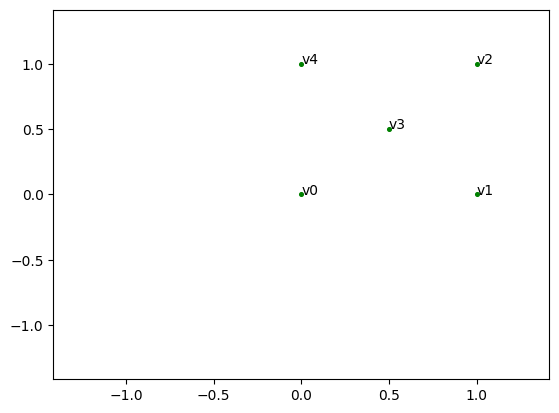

In [9]:
#===============================================================================
# example 4

# another not convex poligon of 5 vertices
vectors4 = [np.array([[0], [0]]), np.array([[1], [0]]),
            np.array([[1], [1]]), np.array([[0.5], [0.5]]),
            np.array([[0], [1]]),]

vectors4 = Vector.cast_to_vector(vectors4)
p4 = Poligon(vectors4)
print(f"is poligon ex. 4 convex? {p4.is_convex()}")
plotter.plot_many(vectors4, with_labels=True)
plotter.show()